Training and evaluation results of ResNet50

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import math
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score
import json
import seaborn as sns
import itertools

In [42]:
from google.colab import drive # Model was trained in google colab
drive.mount('/content/drive') # Mounting the dataset from Google Drive to the Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Loading the dataset
DATA_DIR = '/content/drive/MyDrive/ISproject/Garbage_classification'

# Dataset is a combination of multiple images handpicked from datasets that are available online

#Using Keras API from tensorflow to preprocess the dataset and resize them into 256x256 dimensions
train_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR,validation_split=0.2,seed=42,subset="training",smart_resize=True,image_size=(256,256)) # 80/20 train-test split

test_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR,validation_split=0.2,seed=42,subset="validation",smart_resize=True,image_size=(256,256))


# Approximately a 80/20 split

Found 3522 files belonging to 7 classes.
Using 2818 files for training.
Found 3522 files belonging to 7 classes.
Using 704 files for validation.


In [44]:
class_name = train_data.class_names
numClasses = len(class_name) # 7 classes
print(class_name) # ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']

['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']


In [45]:
baseModel = tf.keras.applications.resnet50.ResNet50(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses) # Pulling a pre-trained model from Keras to put on top of our own layers
for layers in baseModel.layers[:-6]: # Might change the model later
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x) # Using softmax as an activation function since it specializes in multiple class classification

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

In [46]:
# Training and testing the model
epochs = 60
learn_rate = 0.0025

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_data, validation_data=test_data, epochs=epochs) # Takes approximately 2 hours to train using the default machine of google colab

Epoch 1/60


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


89/89 [==============================] - 23s 203ms/step - loss: 84.2016 - accuracy: 0.6033 - val_loss: 13.5375 - val_accuracy: 0.4446
Epoch 2/60
89/89 [==============================] - 18s 192ms/step - loss: 12.4558 - accuracy: 0.6153 - val_loss: 14.7101 - val_accuracy: 0.4006
Epoch 3/60
89/89 [==============================] - 18s 199ms/step - loss: 12.9638 - accuracy: 0.7048 - val_loss: 14.6452 - val_accuracy: 0.5795
Epoch 4/60
89/89 [==============================] - 17s 186ms/step - loss: 13.2043 - accuracy: 0.7392 - val_loss: 15.8491 - val_accuracy: 0.4943
Epoch 5/60
89/89 [==============================] - 17s 187ms/step - loss: 13.6833 - accuracy: 0.7786 - val_loss: 16.1031 - val_accuracy: 0.6548
Epoch 6/60
89/89 [==============================] - 17s 189ms/step - loss: 14.4843 - accuracy: 0.7910 - val_loss: 16.2633 - val_accuracy: 0.5739
Epoch 7/60
89/89 [==============================] - 17s 187ms/step - loss: 14.0150 - accuracy: 0.8141 - val_loss: 14.1757 - val_accuracy: 0.6

In [57]:

model.save('/content/model/model_resnet.h5')
with open('/content/model/history_resnet.json','w') as h:
  json.dump(history, h)


In [58]:
# Run cell to load the model using files
history2 = {}
# Load the model
model2 = tf.keras.models.load_model('/content/drive/MyDrive/ISproject/model/model_resnet.h5')

# Load the history
with open('/content/drive/MyDrive/ISproject/model/history_resnet.json', 'r') as h:
    history2 = json.load(h)

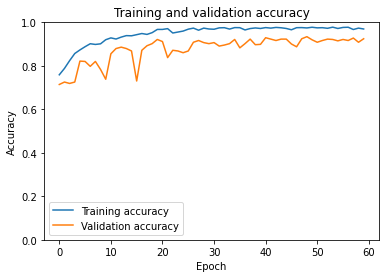

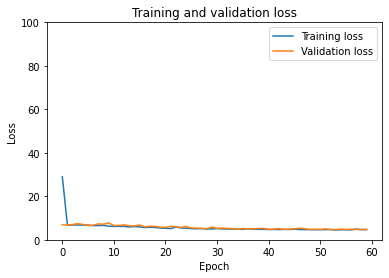

In [59]:
# Graphing the accuracy and loss of the training and testing datasets

# Extract the training and validation accuracy and loss values from the history object
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Plot the training and validation accuracy
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.ylim([0, 1])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim([0,100])
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Confusion matrix


prediction = np.array([])
true_val =  np.array([])
for x, y in test_data: # Getting predicted and true values of the test data and putting it into a numpy array
  prediction = np.concatenate([prediction, np.argmax(model.predict(x), axis = -1)])
  true_val = np.concatenate([true_val, y])

# Computing the confusion matrix
conf_mat = tf.math.confusion_matrix(labels=true_val, predictions=prediction).numpy()





1/1 [==============================] - 0s 36ms/step


Text(0, 0.5, 'True label')

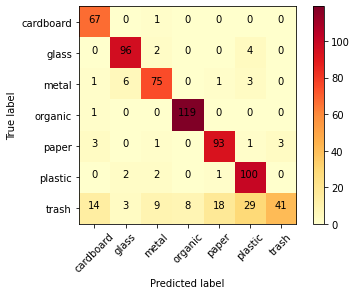

In [51]:
# Plotting the computed confusion matrix
plt.imshow(conf_mat, cmap='YlOrRd', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, "{:,}".format(conf_mat[i, j]),
                  horizontalalignment="center",
                  color="black")
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [52]:
# Calculating the F1-score of the model

# Calculate precision and recall 
precision = precision_score(true_val,prediction,average=None) # Precision of each individual class
precision_dict = {}

precision_avg = precision_score(true_val,prediction,average='macro') # Average precision of all classes


recall = recall_score(true_val,prediction,average=None) # Recall of each individual class
recall_dict = {}
recall_avg = recall_score(true_val,prediction,average='macro') # Average recall of all classes


f1_dict = {}
for i in range(len(precision)): # Filling the dictionaries
  precision_dict[class_name[i]] = precision[i]
  recall_dict[class_name[i]] = recall[i]
  f1_dict[class_name[i]] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) # Calculating f1 score per class

# Calculate F1 score average
f1 = 2 * (precision_avg * recall_avg) / (precision_avg + recall_avg)

print(f"Model precision : {precision_dict}")
print(f"Model precision (average of all classes): {precision_avg}\n")
print(f"Model recall : {recall_dict}")
print(f"Model recall (average of all classes): {recall_avg}\n")
print(f"Model F1-score : {f1_dict}")
print(f"Model F1-score (average of all classes): {f1}")

Model precision : {'cardboard': 0.7790697674418605, 'glass': 0.897196261682243, 'metal': 0.8333333333333334, 'organic': 0.937007874015748, 'paper': 0.8230088495575221, 'plastic': 0.7299270072992701, 'trash': 0.9318181818181818}
Model precision (average of all classes): 0.8473373250211657

Model recall : {'cardboard': 0.9852941176470589, 'glass': 0.9411764705882353, 'metal': 0.872093023255814, 'organic': 0.9916666666666667, 'paper': 0.9207920792079208, 'plastic': 0.9523809523809523, 'trash': 0.3360655737704918}
Model recall (average of all classes): 0.8570669833595915

Model F1-score : {'cardboard': 0.8701298701298702, 'glass': 0.9186602870813397, 'metal': 0.8522727272727274, 'organic': 0.9635627530364372, 'paper': 0.8691588785046729, 'plastic': 0.8264462809917354, 'trash': 0.4939759036144578}
Model F1-score (average of all classes): 0.8521743831237024
